Họ và tên: Phạm Đức Thể

MSSV: 19522253

Lớp: DS200.M21

Predict Flight Delays - 30/06/2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1oGsXPNwJ9ef6TXjF_GGfg6b1dJl60Wpq?usp=sharing)

# **Predict Flight Delays**

## **Import Libraries**

In [1]:
!pip install pyspark==3.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 204.2 MB 33 kB/s 
     |████████████████████████████████| 198 kB 55.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=85700d09b6e01ac109fa7cb2b68f866bcad0e729db07141862fa3aac28fba047
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


In [2]:
import numpy as np
import pandas
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from IPython.core.display import display
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler,StandardScaler
from pyspark.ml.pipeline import PipelineModel

sns.set()

spark = SparkSession.builder.appName('FinalProject').config("spark.executor.memory","16g").getOrCreate()
spark

## **Read Dataset**

In [3]:
PATH = '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 2 2021 - 2022/DS200.M21 - PHÂN TÍCH DỮ LIỆU LỚN/FINAL PROJECT/Predict Flight Delays/'

In [4]:
# Read dataset.csv
dataset = spark.read.csv(PATH+'Dataset/dataset.csv', header=True, inferSchema=True)
dataset.printSchema()
dataset.show(20,False)
dataset.count()

root
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FL_DATE: string (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_AIRLINE_ID: integer (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_AIRPORT_SEQ_ID: integer (nullable = true)
 |-- ORIGIN_CITY_MARKET_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY_NAME: string (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- ORIGIN_STATE_FIPS: integer (nullable = true)
 |-- ORIGIN_STATE_NM: string (nullable = true)
 |-- ORIGIN_WAC: integer (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_AIRPORT_SEQ_ID: integer (nu

2157737

In [5]:
dataset = dataset.withColumn('DATE', f.split('FL_DATE', ' ')[0]).withColumn('ID', f.concat(f.col('DATE'), f.lit('_'), 
                                                                                               f.col('OP_UNIQUE_CARRIER'), f.lit('_'), 
                                                                                               f.col('ORIGIN'), f.lit('_'), 
                                                                                               f.col('DEST'), f.lit('_'), 
                                                                                               f.col('OP_CARRIER_FL_NUM')))
dataset.show(20,False)

+----+-------+-----+------------+-----------+---------------------+-----------------+---------------------+----------+--------+-----------------+-----------------+---------------------+---------------------+------+----------------+----------------+-----------------+---------------+----------+---------------+-------------------+-------------------+----+---------------+--------------+---------------+-------------+--------+------------+--------+---------+-------------+---------+---------------+------------+--------+----------+---------+-------+------------+--------+---------+-------------+---------+---------------+------------+---------+--------+----------------+-------------------+--------+-------+--------+--------------+--------------------+---------+-------------------------+
|YEAR|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|FL_DATE              |OP_UNIQUE_CARRIER|OP_CARRIER_AIRLINE_ID|OP_CARRIER|TAIL_NUM|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN

In [6]:
data = dataset.select('ID', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 
                      'ORIGIN', 'DEST', 'DISTANCE', 'CRS_DEP_TIME', 'DEP_DELAY')
data.printSchema()
data.show(20,False)
data.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: double (nullable = true)

+-------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---------+
|ID                       |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|DEP_DELAY|
+-------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+---------+
|6/2/2021_AA_CLT_MCI_1677 |2      |6    |2           |3          |AA               |CLT   |MCI |808.0   |1850        |1.0      |
|6/3/2021_AA_LGA_MIA_1677 |2

2157737

In [7]:
data.summary().show()

+-------+--------------------+-----------------+-----------------+------------------+------------------+-----------------+-------+-------+-----------------+------------------+------------------+
|summary|                  ID|          QUARTER|            MONTH|      DAY_OF_MONTH|       DAY_OF_WEEK|OP_UNIQUE_CARRIER| ORIGIN|   DEST|         DISTANCE|      CRS_DEP_TIME|         DEP_DELAY|
+-------+--------------------+-----------------+-----------------+------------------+------------------+-----------------+-------+-------+-----------------+------------------+------------------+
|  count|             2157737|          2157737|          2157737|           2157737|           2157737|          2157737|2157737|2157737|          2157737|           2157737|           2157737|
|   mean|                null|2.486636230458114|7.459908691374343|15.781079436465149|3.9420842299130987|             null|   null|   null| 825.634135670844|1327.7717757076048|11.982998391370218|
| stddev|                

## **Prepare data**

In [8]:
# 0: DEP_DELAY <= 0 <=> Không bị trễ.
data_new = data.withColumn('DEP_DELAY', f.when(f.col('DEP_DELAY')<=0, 0).otherwise(f.col('DEP_DELAY')))
# 1: 0 < DEP_DELAY <= 30 minutes <=> Trễ từ 1 đến 30 phút.
data_new = data_new.withColumn('DEP_DELAY', f.when((f.col('DEP_DELAY')>0) & (f.col('DEP_DELAY')<=30), 1).otherwise(f.col('DEP_DELAY')))
# 2: DEP_DELAY > 30 minutes <=> Trễ hơn 30 phút hoặc hủy chuyến.
data_new = data_new.withColumn('DEP_DELAY', f.when(f.col('DEP_DELAY')>30, 2).otherwise(f.col('DEP_DELAY')))
# Đổi tên DEP_DELAY -> LABEL
data_new = data_new.withColumnRenamed('DEP_DELAY', 'LABEL')
# Chuyển kiểu dữ liệu FLOAT -> INT
data_new = data_new.withColumn('LABEL', f.col('LABEL').cast("INT"))
# # scale CRS_DEP_TIME
# data_new = data_new.withColumn('CRS_DEP_TIME', f.col('CRS_DEP_TIME')/100)
# # scale DISTANCE
# data_new = data_new.withColumn('DISTANCE', f.col('DISTANCE')/100)

In [9]:
data_new.printSchema()
data_new.show()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/2/2021_AA_CLT_M...|      2|    6|           2|          3|               AA|   CLT| MCI|   808.0|        1850|    1|
|6/3/2021_AA_LGA_M...|      2|    6|           3|          4|      

In [10]:
train, test = data_new.randomSplit(weights=[0.8,0.2], seed=2022)

In [11]:
train.printSchema()
train.show()
train.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141|    0|
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|      

1726419

In [12]:
test.printSchema()
test.show()
test.count()

root
 |-- ID: string (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- LABEL: integer (nullable = true)

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655|    0|
|6/1/2021_9E_ABY_A...|      2|    6|           1|          2|      

431318

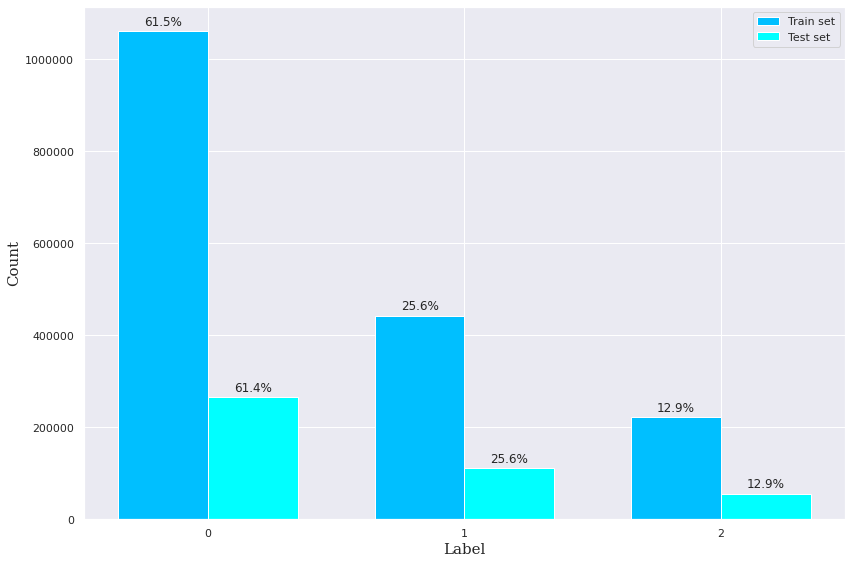

In [13]:
df_train = train.select('LABEL').toPandas()
df_test = test.select('LABEL').toPandas()

label_train = list(df_train.LABEL.value_counts())
label_test = list(df_test.LABEL.value_counts())

rate_train = [round(x * 100 / sum(label_train), 1) for x in label_train]
rate_test = [round(x * 100 / sum(label_test), 1) for x in label_test]

labels = ['G1', 'G2', 'G3']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(x - width/2, label_train, width, label='Train set', color ='#00BFFF')
rects2 = ax.bar(x + width/2, label_test, width, label='Test set', color ='#00FFFF')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xticklabels(labels)
ax.legend()

def autolabel_train(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_train[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
def autolabel_test(rects):
    i = 0
    for rect in rects:
        height = rect.get_height()
        height_2 = str(rate_test[i]) + '%'
        i = i + 1
        ax.annotate('{}'.format(height_2),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_train(rects1)
autolabel_test(rects2)
# Adding Xticks
plt.xlabel('Label', fontsize = 15, fontfamily='serif')
plt.ylabel('Count', fontsize = 15, fontfamily='serif')
plt.xticks([r for r in range(len(label_train))], ['0', '1', '2'])
fig.tight_layout()
plt.show()

## **Build & Evaluation Model**

### Logistic Regression

#### Training model

In [14]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [15]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [16]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec', 
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [ ]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [17]:
LR = LogisticRegression(featuresCol='features',labelCol='LABEL')

In [18]:
pipeline = Pipeline(stages=[stringIndexer, 
                            oneHotEncoder, 
                            assembler, LR])

In [19]:
%%time
model_LR = pipeline.fit(train)

CPU times: user 1.48 s, sys: 180 ms, total: 1.66 s
Wall time: 5min 2s


#### Evaluation model

##### Train

In [20]:
Trained = model_LR.transform(train)
Trained.show(truncate=False)
Trained.count()

+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+-----------------------------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------+----------+
|ID                      |QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|ORIGINVec        |DESTVec          |features                                                                     |rawPrediction                                                |probability                                                  |prediction|
+------------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----

1726419

In [21]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1525978|
|       1.0| 187893|
|       2.0|  12548|
+----------+-------+




**Không Scale dữ liệu**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1525978|
|       1.0| 187893|
|       2.0|  12548|
+----------+-------+
```

**Sacle = chia 100**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1525978|
|       1.0| 187893|
|       2.0|  12548|
+----------+-------+
```

**Sacle = StandardScaler**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1525978|
|       1.0| 187893|
|       2.0|  12548|
+----------+-------+
```



In [22]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL, 
                            predicted_train_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6579    0.9459    0.7760   1061322
           1     0.4505    0.1912    0.2684    442816
           2     0.3977    0.0224    0.0425    222281

    accuracy                         0.6334   1726419
   macro avg     0.5020    0.3865    0.3623   1726419
weighted avg     0.5712    0.6334    0.5514   1726419




**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.66      0.95      0.78   1061322
           1       0.45      0.19      0.27    442816
           2       0.40      0.02      0.04    222281

    accuracy                           0.63   1726419
   macro avg       0.50      0.39      0.36   1726419
weighted avg       0.57      0.63      0.55   1726419

```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.66      0.95      0.78   1061322
           1       0.45      0.19      0.27    442816
           2       0.40      0.02      0.04    222281

    accuracy                           0.63   1726419
   macro avg       0.50      0.39      0.36   1726419
weighted avg       0.57      0.63      0.55   1726419

```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.66      0.95      0.78   1061322
           1       0.45      0.19      0.27    442816
           2       0.40      0.02      0.04    222281

    accuracy                           0.63   1726419
   macro avg       0.50      0.39      0.36   1726419
weighted avg       0.57      0.63      0.55   1726419

```


In [23]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 63.34152%
F1-Micro: 63.34152%
F1-Macro: 36.23129%



**Không scale dữ liệu**
```
===============Training Data===============
Accuracy: 63.34152%
F1-Micro: 63.34152%
F1-Macro: 36.23129%
```

**Scale = chia 100**
```
===============Training Data===============
Accuracy: 63.34152%
F1-Micro: 63.34152%
F1-Macro: 36.23129%
```

**Sacle = StandardScaler**
```
===============Training Data===============
Accuracy: 63.34152%
F1-Micro: 63.34152%
F1-Macro: 36.23129%
```


##### Test

In [24]:
Tested = model_LR.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [25]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|380633|
|       1.0| 47582|
|       2.0|  3103|
+----------+------+




**Không scale dữ liệu**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|380633|
|       1.0| 47582|
|       2.0|  3103|
+----------+------+
```

**Scale = chia 100**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|380633|
|       1.0| 47582|
|       2.0|  3103|
+----------+------+
```
**Sacle = StandardScaler**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|380633|
|       1.0| 47582|
|       2.0|  3103|
+----------+------+
```

In [26]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL, 
                            predicted_test_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6580    0.9451    0.7758    265007
           1     0.4500    0.1937    0.2708    110525
           2     0.3877    0.0216    0.0409     55786

    accuracy                         0.6331    431318
   macro avg     0.4985    0.3868    0.3625    431318
weighted avg     0.5697    0.6331    0.5514    431318




**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.66      0.95      0.78    265007
           1       0.45      0.19      0.27    110525
           2       0.39      0.02      0.04     55786

    accuracy                           0.63    431318
   macro avg       0.50      0.39      0.36    431318
weighted avg       0.57      0.63      0.55    431318
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.66      0.95      0.78    265007
           1       0.45      0.19      0.27    110525
           2       0.39      0.02      0.04     55786

    accuracy                           0.63    431318
   macro avg       0.50      0.39      0.36    431318
weighted avg       0.57      0.63      0.55    431318
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.66      0.95      0.78    265007
           1       0.45      0.19      0.27    110525
           2       0.39      0.02      0.04     55786

    accuracy                           0.63    431318
   macro avg       0.50      0.39      0.36    431318
weighted avg       0.57      0.63      0.55    431318
```

In [27]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 63.30828%
F1-Micro: 63.30828%
F1-Macro: 36.24986%



**Không scale dữ liệu**
```
===============Testing Data===============
Accuracy: 63.30828%
F1-Micro: 63.30828%
F1-Macro: 36.24986%
```

**Scale = chia 100**
```
===============Testing Data===============
Accuracy: 63.30828%
F1-Micro: 63.30828%
F1-Macro: 36.24986%
```

**Sacle = StandardScaler**
```
===============Testing Data===============
Accuracy: 63.30828%
F1-Micro: 63.30828%
F1-Macro: 36.24986%
```

#### Save & Load model

In [28]:
model_LR.write().overwrite().save(PATH+'Model/LR')

In [29]:
model_LR_load = PipelineModel.load(PATH+'Model/LR')

###Decision Tree

#### Training model

In [30]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [31]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [32]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec', 
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [33]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [34]:
DT = DecisionTreeClassifier(maxDepth=16,featuresCol='features',labelCol='LABEL')# 

In [35]:
pipeline = Pipeline(stages=[stringIndexer, 
                            oneHotEncoder, 
                            assembler, DT])

In [36]:
%%time
model_DT = pipeline.fit(train)

CPU times: user 10.1 s, sys: 1.11 s, total: 11.3 s
Wall time: 35min 43s


#### Evaluation model

##### Train

In [37]:
Trained = model_DT.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141

1726419

In [38]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1443803|
|       1.0| 203142|
|       2.0|  79474|
+----------+-------+




**không scale dữ liệu**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1438335|
|       1.0| 207355|
|       2.0|  80729|
+----------+-------+
```

**Scale = chia 100**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1446881|
|       1.0| 206511|
|       2.0|  73027|
+----------+-------+

```

**Sacle = StandardScaler**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1452435|
|       1.0| 198500|
|       2.0|  75484|
+----------+-------+
```

In [39]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL, 
                            predicted_train_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6924    0.9419    0.7981   1061322
           1     0.5593    0.2566    0.3518    442816
           2     0.6046    0.2162    0.3185    222281

    accuracy                         0.6727   1726419
   macro avg     0.6188    0.4716    0.4895   1726419
weighted avg     0.6470    0.6727    0.6219   1726419




**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.69      0.94      0.80   1061322
           1       0.55      0.26      0.35    442816
           2       0.60      0.22      0.32    222281

    accuracy                           0.67   1726419
   macro avg       0.62      0.47      0.49   1726419
weighted avg       0.65      0.67      0.62   1726419
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.69      0.94      0.80   1061322
           1       0.56      0.26      0.35    442816
           2       0.63      0.21      0.31    222281

    accuracy                           0.67   1726419
   macro avg       0.63      0.47      0.49   1726419
weighted avg       0.65      0.67      0.62   1726419
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.69      0.94      0.79   1061322
           1       0.54      0.24      0.33    442816
           2       0.58      0.20      0.29    222281

    accuracy                           0.67   1726419
   macro avg       0.60      0.46      0.47   1726419
weighted avg       0.63      0.67      0.61   1726419
```

In [40]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 67.26913%
F1-Micro: 67.26913%
F1-Macro: 48.94603%



**Không scale dữ liệu**
```
===============Training Data===============
Accuracy: 67.23744%
F1-Micro: 67.23744%
F1-Macro: 49.04317%
```

**Scale = chia 100**
```
===============Training Data===============
Accuracy: 67.24364%
F1-Micro: 67.24364%
F1-Macro: 48.72211%
```

**Sacle = StandardScaler**
```
===============Training Data===============
Accuracy: 66.56200%
F1-Micro: 66.56200%
F1-Macro: 47.33711%
```

##### Test

In [41]:
Tested = model_DT.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [42]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|360391|
|       1.0| 50833|
|       2.0| 20094|
+----------+------+




**Không scale dữ liệu**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|359198|
|       1.0| 51729|
|       2.0| 20391|
+----------+------+
```

**Scale = chia 100**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|361519|
|       1.0| 51426|
|       2.0| 18373|
+----------+------+
```

**Sacle = StandardScaler**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|362750|
|       1.0| 49547|
|       2.0| 19021|
+----------+------+
```

In [43]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL, 
                            predicted_test_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.6819    0.9274    0.7859    265007
           1     0.4772    0.2195    0.3007    110525
           2     0.5040    0.1816    0.2669     55786

    accuracy                         0.6495    431318
   macro avg     0.5544    0.4428    0.4512    431318
weighted avg     0.6065    0.6495    0.5945    431318




**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.68      0.93      0.79    265007
           1       0.48      0.22      0.30    110525
           2       0.50      0.18      0.27     55786

    accuracy                           0.65    431318
   macro avg       0.55      0.44      0.45    431318
weighted avg       0.61      0.65      0.60    431318
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.68      0.93      0.79    265007
           1       0.47      0.22      0.30    110525
           2       0.52      0.17      0.26     55786

    accuracy                           0.65    431318
   macro avg       0.56      0.44      0.45    431318
weighted avg       0.61      0.65      0.59    431318
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.68      0.93      0.79    265007
           1       0.48      0.21      0.29    110525
           2       0.51      0.17      0.26     55786

    accuracy                           0.65    431318
   macro avg       0.55      0.44      0.45    431318
weighted avg       0.60      0.65      0.59    431318
```

In [44]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 64.95115%
F1-Micro: 64.95115%
F1-Macro: 45.11903%



**Không scale dữ liệu**
```
===============Testing Data===============
Accuracy: 64.95115%
F1-Micro: 64.95115%
F1-Macro: 45.26996%
```

**Scale = chia 100**
```
===============Testing Data===============
Accuracy: 64.86838%
F1-Micro: 64.86838%
F1-Macro: 44.72475%
```

**Sacle = StandardScaler**
```
===============Testing Data===============
Accuracy: 64.85772%
F1-Micro: 64.85772%
F1-Macro: 44.57912%
```

#### Save & Load model

In [45]:
model_DT.write().overwrite().save(PATH+'Model/DT')

In [46]:
model_DT_load = PipelineModel.load(PATH+'Model/DT')

### Random Forest

#### Training model

In [47]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [48]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [49]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec', 
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [50]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [51]:
RF = RandomForestClassifier(maxDepth=10, numTrees = 3, featuresCol='features', labelCol='LABEL')#

In [52]:
pipeline = Pipeline(stages=[stringIndexer, 
                            oneHotEncoder, 
                            assembler, RF])

In [53]:
%%time
model_RF = pipeline.fit(train)

CPU times: user 1.88 s, sys: 217 ms, total: 2.1 s
Wall time: 6min


#### Evaluation model

##### Train

In [54]:
Trained = model_RF.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141

1726419

In [55]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1659509|
|       1.0|  66910|
+----------+-------+




**Không scale dữ liệu**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1723538|
|       1.0|   2862|
|       2.0|     19|
+----------+-------+
```

**Scale = chia 100**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1711107|
|       1.0|  15310|
|       2.0|      2|
+----------+-------+
```

**Sacle = StandardScaler**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1703003|
|       1.0|  23397|
|       2.0|     19|
+----------+-------+
```

In [56]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL, 
                            predicted_train_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6293    0.9840    0.7676   1061322
           1     0.4422    0.0668    0.1161    442816
           2     0.0000    0.0000    0.0000    222281

    accuracy                         0.6220   1726419
   macro avg     0.3572    0.3503    0.2946   1726419
weighted avg     0.5003    0.6220    0.5017   1726419



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.62      1.00      0.76   1061322
           1       0.56      0.00      0.01    442816
           2       0.74      0.00      0.00    222281

    accuracy                           0.62   1726419
   macro avg       0.64      0.33      0.26   1726419
weighted avg       0.62      0.62      0.47   1726419
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.62      1.00      0.76   1061322
           1       0.48      0.02      0.03    442816
           2       0.50      0.00      0.00    222281

    accuracy                           0.62   1726419
   macro avg       0.53      0.34      0.27   1726419
weighted avg       0.57      0.62      0.48   1726419
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.62      1.00      0.76   1061322
           1       0.49      0.03      0.05    442816
           2       0.53      0.00      0.00    222281

    accuracy                           0.62   1726419
   macro avg       0.55      0.34      0.27   1726419
weighted avg       0.58      0.62      0.48   1726419
```



In [57]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 62.20245%
F1-Micro: 62.20245%
F1-Macro: 29.45714%



**Không scale dữ liệu**
```
===============Training Data===============
Accuracy: 61.53454%
F1-Micro: 61.53454%
F1-Macro: 25.63493%
```

**Scale = chia 100**
```
===============Training Data===============
Accuracy: 61.77098%
F1-Micro: 61.77098%
F1-Macro: 26.53076%
```

**Sacle = StandardScaler**
```
===============Training Data===============
Accuracy: 61.89899%
F1-Micro: 61.89899%
F1-Macro: 27.15063%
```

##### Test

In [58]:
Tested = model_RF.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [59]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|414372|
|       1.0| 16946|
+----------+------+




**Không scale dữ liệu**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|430599|
|       1.0|   714|
|       2.0|     5|
+----------+------+
```

**Scale = chia 100**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|427478|
|       1.0|  3839|
|       2.0|     1|
+----------+------+
```

**Sacle = StandardScaler**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|425411|
|       1.0|  5906|
|       2.0|     1|
+----------+------+
```

In [60]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL, 
                            predicted_test_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.6292    0.9839    0.7675    265007
           1     0.4445    0.0682    0.1182    110525
           2     0.0000    0.0000    0.0000     55786

    accuracy                         0.6220    431318
   macro avg     0.3579    0.3507    0.2952    431318
weighted avg     0.5005    0.6220    0.5019    431318



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.62      1.00      0.76    265007
           1       0.51      0.00      0.01    110525
           2       0.20      0.00      0.00     55786

    accuracy                           0.61    431318
   macro avg       0.44      0.33      0.26    431318
weighted avg       0.53      0.61      0.47    431318
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.62      1.00      0.76    265007
           1       0.47      0.02      0.03    110525
           2       0.00      0.00      0.00     55786

    accuracy                           0.62    431318
   macro avg       0.36      0.34      0.27    431318
weighted avg       0.50      0.62      0.48    431318
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.62      1.00      0.76    265007
           1       0.49      0.03      0.05    110525
           2       1.00      0.00      0.00     55786

    accuracy                           0.62    431318
   macro avg       0.70      0.34      0.27    431318
weighted avg       0.64      0.62      0.48    431318
```

In [61]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 62.19564%
F1-Micro: 62.19564%
F1-Macro: 29.52465%



**Không scale dữ liệu**
```
===============Testing Data===============
Accuracy: 61.48735%
F1-Micro: 61.48735%
F1-Macro: 25.60213%
```

**Scale = chia 100**
```
===============Testing Data===============
Accuracy: 61.73566%
F1-Micro: 61.73566%
F1-Macro: 26.52114%
```

**Sacle = StandardScaler**
```
===============Testing Data===============
Accuracy: 61.86294%
F1-Micro: 61.86294%
F1-Macro: 27.13769%
```

#### Save & Load model

In [62]:
model_RF.write().overwrite().save(PATH+'Model/RF')

In [63]:
model_RF_load = PipelineModel.load(PATH+'Model/RF')

### Naive Bayes

#### Training model

In [64]:
stringIndexer = StringIndexer(inputCols=['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST'],
                              outputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'])

In [65]:
oneHotEncoder = OneHotEncoder(inputCols=['OP_UNIQUE_CARRIERIndex', 'ORIGINIndex', 'DESTIndex'],
                              outputCols=['OP_UNIQUE_CARRIERVec', 'ORIGINVec','DESTVec'])

In [66]:
assembler = VectorAssembler(inputCols=['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIERVec', 'ORIGINVec', 
                                       'DESTVec', 'DISTANCE', 'CRS_DEP_TIME'], outputCol='features')

In [67]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [68]:
NB = NaiveBayes(featuresCol='features',labelCol='LABEL',smoothing=0.0003,modelType="multinomial")# 

In [69]:
pipeline = Pipeline(stages=[stringIndexer, 
                            oneHotEncoder, 
                            assembler, NB])

In [70]:
%%time
model_NB = pipeline.fit(train)

CPU times: user 227 ms, sys: 26.4 ms, total: 254 ms
Wall time: 38.5 s


#### Evaluation model

##### Train

In [71]:
Trained = model_NB.transform(train)
Trained.show()
Trained.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|        1141

1726419

In [72]:
Trained.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|154134|
|       1.0|664173|
|       2.0|908112|
+----------+------+




**Không scale dữ liệu**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|154134|
|       1.0|664173|
|       2.0|908112|
+----------+------+
```

**Scale = chia 100**
```
+----------+-------+
|prediction|  count|
+----------+-------+
|       0.0|1309417|
|       1.0| 367332|
|       2.0|  49670|
+----------+-------+
```

**Sacle = StandardScaler**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|640618|
|       1.0|824403|
|       2.0|261398|
+----------+------+
```

In [73]:
predicted_train = Trained.select("prediction", 'LABEL')
predicted_train_score = predicted_train.toPandas()

print(classification_report(predicted_train_score.LABEL, 
                            predicted_train_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.7089    0.1030    0.1798   1061322
           1     0.2791    0.4187    0.3350    442816
           2     0.1432    0.5850    0.2301    222281

    accuracy                         0.2460   1726419
   macro avg     0.3771    0.3689    0.2483   1726419
weighted avg     0.5259    0.2460    0.2261   1726419




**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.71      0.10      0.18   1061322
           1       0.28      0.42      0.33    442816
           2       0.14      0.59      0.23    222281

    accuracy                           0.25   1726419
   macro avg       0.38      0.37      0.25   1726419
weighted avg       0.53      0.25      0.23   1726419
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.67      0.83      0.74   1061322
           1       0.38      0.32      0.35    442816
           2       0.33      0.07      0.12    222281

    accuracy                           0.60   1726419
   macro avg       0.46      0.41      0.40   1726419
weighted avg       0.55      0.60      0.56   1726419
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.73      0.44      0.55   1061322
           1       0.32      0.59      0.41    442816
           2       0.19      0.22      0.20    222281

    accuracy                           0.45   1726419
   macro avg       0.41      0.42      0.39   1726419
weighted avg       0.55      0.45      0.47   1726419
```



In [74]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_train = evaluator.evaluate(Trained)
f1_mic = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_train_score['LABEL'], 
                  predicted_train_score['prediction'], 
                  average = 'macro')

print('='*15+'Training Data'+'='*15)
print(f'Accuracy: {accuracy_train*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Training Data===============
Accuracy: 24.60104%
F1-Micro: 24.60104%
F1-Macro: 24.82850%



**Không scale dữ liệu**
```
===============Training Data===============
Accuracy: 24.60104%
F1-Micro: 24.60104%
F1-Macro: 24.82850%
```

**Scale = chia 100**
```
===============Training Data===============
Accuracy: 60.07018%
F1-Micro: 60.07018%
F1-Macro: 40.25651%
```

**Sacle = StandardScaler**
```
===============Training Data===============
Accuracy: 44.95653%
F1-Micro: 44.95653%
F1-Macro: 38.75068%
```

##### Test

In [75]:
Tested = model_NB.transform(test)
Tested.show()
Tested.count()

+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|                  ID|QUARTER|MONTH|DAY_OF_MONTH|DAY_OF_WEEK|OP_UNIQUE_CARRIER|ORIGIN|DEST|DISTANCE|CRS_DEP_TIME|LABEL|OP_UNIQUE_CARRIERIndex|ORIGINIndex|DESTIndex|OP_UNIQUE_CARRIERVec|        ORIGINVec|          DESTVec|            features|       rawPrediction|         probability|prediction|
+--------------------+-------+-----+------------+-----------+-----------------+------+----+--------+------------+-----+----------------------+-----------+---------+--------------------+-----------------+-----------------+--------------------+--------------------+--------------------+----------+
|6/1/2021_9E_ABE_A...|      2|    6|           1|          2|               9E|   ABE| ATL|   692.0|         655

431318

In [76]:
Tested.select('prediction').groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0| 38436|
|       1.0|166053|
|       2.0|226829|
+----------+------+




**Không scale dữ liệu**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0| 38436|
|       1.0|166053|
|       2.0|226829|
+----------+------+
```

**Scale = chia 100**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|326982|
|       1.0| 91725|
|       2.0| 12611|
+----------+------+
```

**Sacle = StandardScaler**
```
+----------+------+
|prediction| count|
+----------+------+
|       0.0|159446|
|       1.0|206594|
|       2.0| 65278|
+----------+------+
```

In [77]:
predicted_test = Tested.select("prediction", 'LABEL')
predicted_test_score = predicted_test.toPandas()

from sklearn.metrics import classification_report
print(classification_report(predicted_test_score.LABEL, 
                            predicted_test_score.prediction, 
                            target_names=['0', '1', '2'], digits=4))

              precision    recall  f1-score   support

           0     0.7133    0.1035    0.1807    265007
           1     0.2783    0.4181    0.3341    110525
           2     0.1439    0.5853    0.2311     55786

    accuracy                         0.2464    431318
   macro avg     0.3785    0.3689    0.2486    431318
weighted avg     0.5282    0.2464    0.2265    431318




**Không scale dữ liệu**
```
              precision    recall  f1-score   support

           0       0.71      0.10      0.18    265007
           1       0.28      0.42      0.33    110525
           2       0.14      0.59      0.23     55786

    accuracy                           0.25    431318
   macro avg       0.38      0.37      0.25    431318
weighted avg       0.53      0.25      0.23    431318
```

**Scale = chia 100**
```
              precision    recall  f1-score   support

           0       0.67      0.83      0.74    265007
           1       0.38      0.32      0.34    110525
           2       0.32      0.07      0.12     55786

    accuracy                           0.60    431318
   macro avg       0.46      0.41      0.40    431318
weighted avg       0.55      0.60      0.56    431318
```

**Sacle = StandardScaler**
```
              precision    recall  f1-score   support

           0       0.73      0.44      0.55    265007
           1       0.32      0.59      0.41    110525
           2       0.18      0.22      0.20     55786

    accuracy                           0.45    431318
   macro avg       0.41      0.41      0.39    431318
weighted avg       0.55      0.45      0.47    431318
```

In [78]:
evaluator = MulticlassClassificationEvaluator(labelCol='LABEL', metricName='accuracy')
accuracy_test = evaluator.evaluate(Tested)
f1_mic = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'micro')
f1_mac = f1_score(predicted_test_score['LABEL'], 
                  predicted_test_score['prediction'], 
                  average = 'macro')

print('='*15+'Testing Data'+'='*15)
print(f'Accuracy: {accuracy_test*100:.5f}%')
print(f'F1-Micro: {f1_mic*100:.5f}%')
print(f'F1-Macro: {f1_mac*100:.5f}%')

===============Testing Data===============
Accuracy: 24.64006%
F1-Micro: 24.64006%
F1-Macro: 24.86390%



**Không scale dữ liệu**
```
===============Testing Data===============
Accuracy: 24.64006%
F1-Micro: 24.64006%
F1-Macro: 24.86390%
```

**Scale = chia 100**
```
===============Testing Data===============
Accuracy: 60.00700%
F1-Micro: 60.00700%
F1-Macro: 40.22980%
```

**Sacle = StandardScaler**
```
===============Testing Data===============
Accuracy: 44.73382%
F1-Micro: 44.73382%
F1-Macro: 38.50216%
```



#### Save & Load model

In [79]:
model_NB.write().overwrite().save(PATH+'Model/NB')

In [80]:
model_NB_load = PipelineModel.load(PATH+'Model/NB')